In [116]:
#Stacked LSTM

#modules
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm.notebook import tqdm
import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_poisson_deviance
import haha


from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

#random seed sehingga seed modelling pada module tensorflow dapat direplikasi
tf.random.set_seed(7)
log_dir = "../../assets/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [143]:
#load dataset
df=pd.read_csv("../../Data/Harian/Rata Harian.csv").iloc[:,2]

#get data from 15 latest months
df=df[-(30*15):]

In [144]:
#Rescale the data to the range of 0-to-1
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df.values.reshape(-1,1))
df=scaler.transform(df.values.reshape(-1,1))

In [145]:
#train test split; train 12 months, 3 months for testing
train=df[:30*12]; test=df[30*12:]

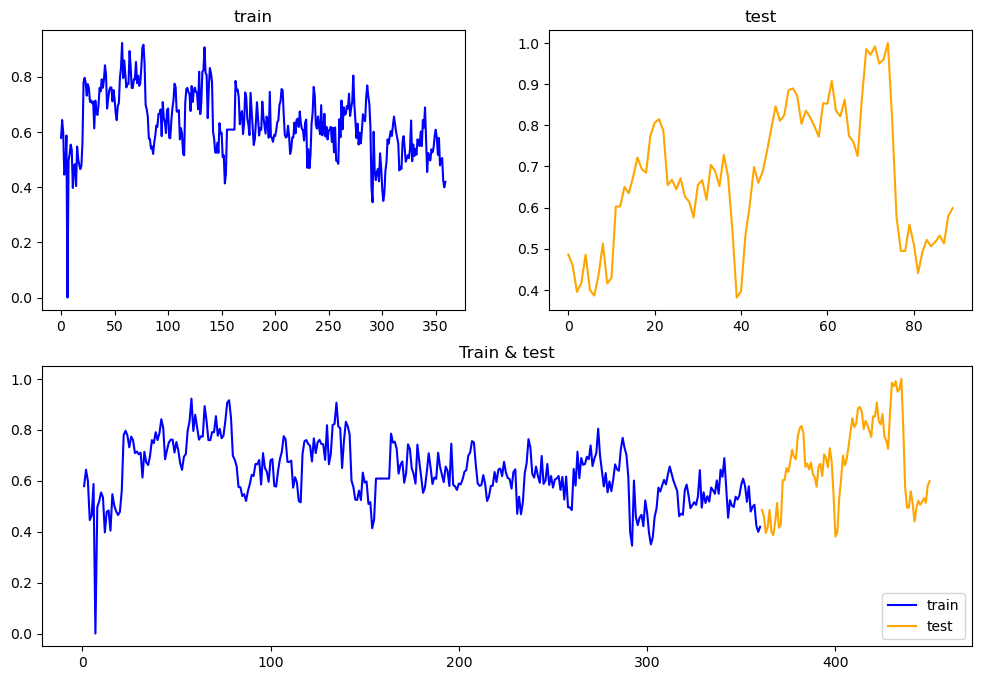

In [146]:
haha.plottraintest(train, test)

In [147]:
# reshape into X=t and Y=t+1

t=15
trainX, trainY = haha.lag(train,t)
testX, testY = haha.lag(test,t)

In [148]:
#ubah data sehingga kompatibel dengan shape input model
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [149]:
def r2scoremetrics(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - (SS_res/SS_tot) )

def thecallback():
    return [keras.callbacks.ModelCheckpoint(log_dir+"/callbacks", save_weights_only=True),
            tf.keras.callbacks.TensorBoard(log_dir)]

In [150]:
batch_size=32

#create model
def getmodel_compile():
    model=keras.Sequential([
        
        keras.layers.LSTM(4, input_shape=(t, 1), return_sequences=True),                   #input and 1st memory block
        keras.layers.LSTM(8),                                          #2nd memory block
        keras.layers.Dense(1)])                                                                                             #output (pakai 1 karena output berbentuk regresi)
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[r2scoremetrics, keras.metrics.MeanAbsolutePercentageError()])
    return model

In [151]:
model=getmodel_compile()

thehistory=model.fit(trainX, trainY, epochs=1000, validation_data=(testX, testY), batch_size=batch_size, verbose=1, callbacks=thecallback())

Epoch 1/1000
11/11 [==============================] - 4s 93ms/step - loss: 0.1894 - r2scoremetrics: -16.5131 - mean_absolute_percentage_error: 65.0460 - val_loss: 0.1816 - val_r2scoremetrics: -22.9935 - val_mean_absolute_percentage_error: 54.2841
Epoch 2/1000
11/11 [==============================] - 0s 21ms/step - loss: 0.0779 - r2scoremetrics: -6.4908 - mean_absolute_percentage_error: 38.8148 - val_loss: 0.0620 - val_r2scoremetrics: -3.3931 - val_mean_absolute_percentage_error: 27.7337
Epoch 3/1000
11/11 [==============================] - 0s 21ms/step - loss: 0.0143 - r2scoremetrics: -0.2820 - mean_absolute_percentage_error: 14.7501 - val_loss: 0.0211 - val_r2scoremetrics: -10.8194 - val_mean_absolute_percentage_error: 18.9242
Epoch 4/1000
11/11 [==============================] - 0s 21ms/step - loss: 0.0142 - r2scoremetrics: -0.3468 - mean_absolute_percentage_error: 17.3523 - val_loss: 0.0211 - val_r2scoremetrics: -9.7243 - val_mean_absolute_percentage_error: 18.7500
Epoch 5/1000
11/1

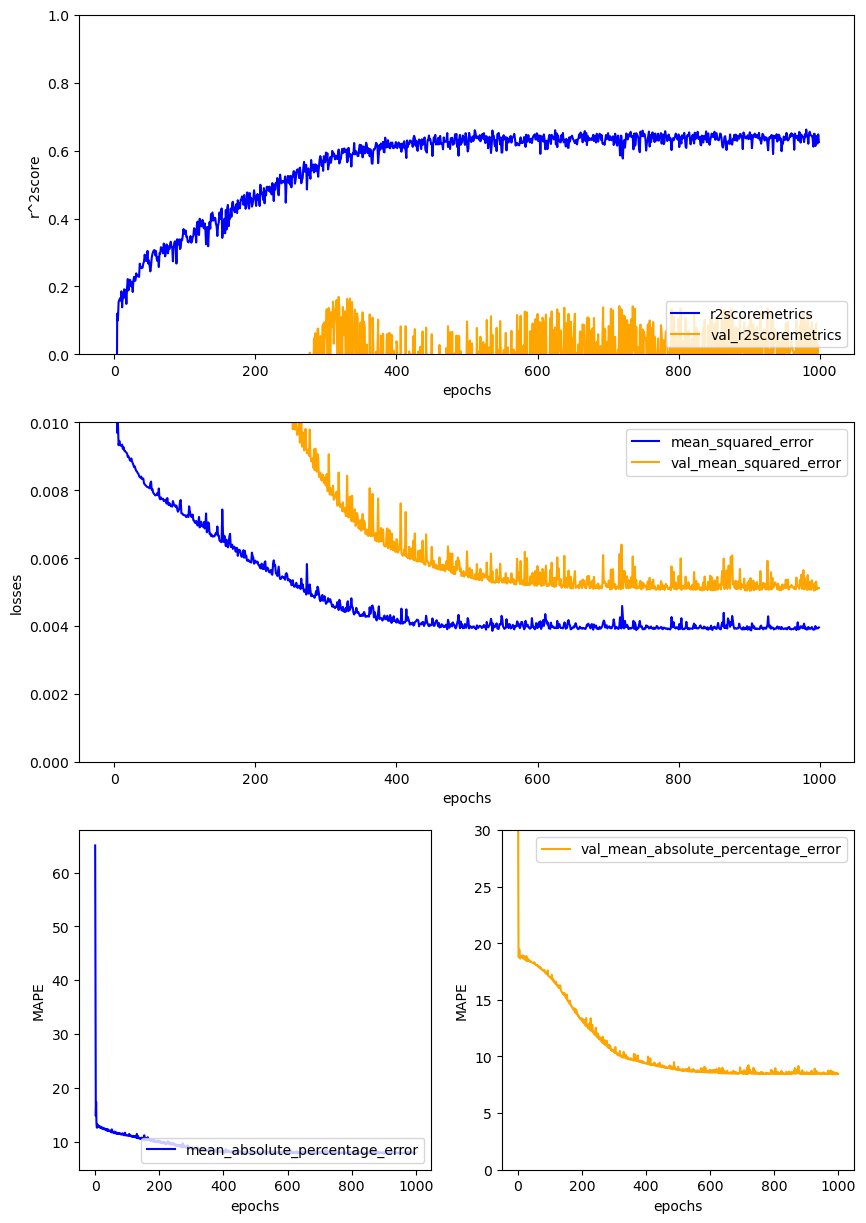

In [152]:
def theplot(history):
    fig = plt.figure(figsize=(10,15))
    ax=fig.add_subplot(3,1,1)
    ax.plot(history.history["r2scoremetrics"], label="r2scoremetrics", c="blue")
    ax.plot(history.history["val_r2scoremetrics"], label="val_r2scoremetrics", c="orange")
    ax.set_xlabel("epochs")
    ax.set_ylabel("r^2score")
    ax.legend(loc="lower right")
    ax.set_ylim(0,1)
    
    ax=fig.add_subplot(3,1,2)
    ax.plot(history.history["loss"], label="mean_squared_error", c="blue")
    ax.plot(history.history["val_loss"], label="val_mean_squared_error", c="orange")
    ax.legend(loc="upper right")
    ax.set_ylim(0,0.01)
    ax.set_xlabel("epochs")
    ax.set_ylabel("losses")
    
    ax=fig.add_subplot(3,2,5)
    ax.plot(history.history["mean_absolute_percentage_error"], label="mean_absolute_percentage_error", c="blue")
    ax.legend(loc="lower right")
    ax.set_xlabel("epochs")
    ax.set_ylabel("MAPE")
    
    ax=fig.add_subplot(3,2,6)
    ax.plot(history.history["val_mean_absolute_percentage_error"], label="val_mean_absolute_percentage_error", c="orange")
    ax.legend(loc="upper right")
    ax.set_xlabel("epochs")
    ax.set_ylabel("MAPE")
    ax.set_ylim(0,30)

theplot(thehistory)

In [153]:
model.save("../../assets/testt15.keras")

In [ ]:
model=keras.models.load_model("../../assets/test.keras")

In [154]:
#predict
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX, batch_size=batch_size)

3/3 [==============================] - 0s 4ms/step


In [155]:
# invert scale
trainPredict = scaler.inverse_transform(trainPredict).flatten()
testPredict = scaler.inverse_transform(testPredict).flatten()

df=scaler.inverse_transform(df)
testY = scaler.inverse_transform([testY]).flatten()
trainY = scaler.inverse_transform([trainY]).flatten()

In [156]:
# Evaluation metrices RMSE and MAE
import math
print("Train")
print(f'RMSE    :   {math.sqrt(mean_squared_error(trainY,trainPredict))}')
print(f'MSE     :   {mean_squared_error(trainY,trainPredict)}')
print(f'MAE     :   {mean_absolute_error(trainY,trainPredict)}')
print(f'MAPE    :   {mean_absolute_percentage_error(trainY,trainPredict)}')
print(f'R2score :   {r2_score(trainY, trainPredict)}')


print("\nTest")
print(f'RMSE    :   {math.sqrt(mean_squared_error(testY,testPredict))}')
print(f'MSE     :   {mean_squared_error(testY,testPredict)}')
print(f'MAE     :   {mean_absolute_error(testY,testPredict)}')
print(f'MAPE    :   {mean_absolute_percentage_error(testY,testPredict)}')
print(f'R2score :   {r2_score(testY, testPredict)}')

Train
RMSE    :   4.947421679358696
MSE     :   24.476981273388414
MAE     :   3.8085537991782483
MAPE    :   0.020078664199733722
R2score :   0.6653614792486056

Test
RMSE    :   5.681757201363494
MSE     :   32.28236489524592
MAE     :   4.436930728030273
MAPE    :   0.022762563307709247
R2score :   0.7711088062748273


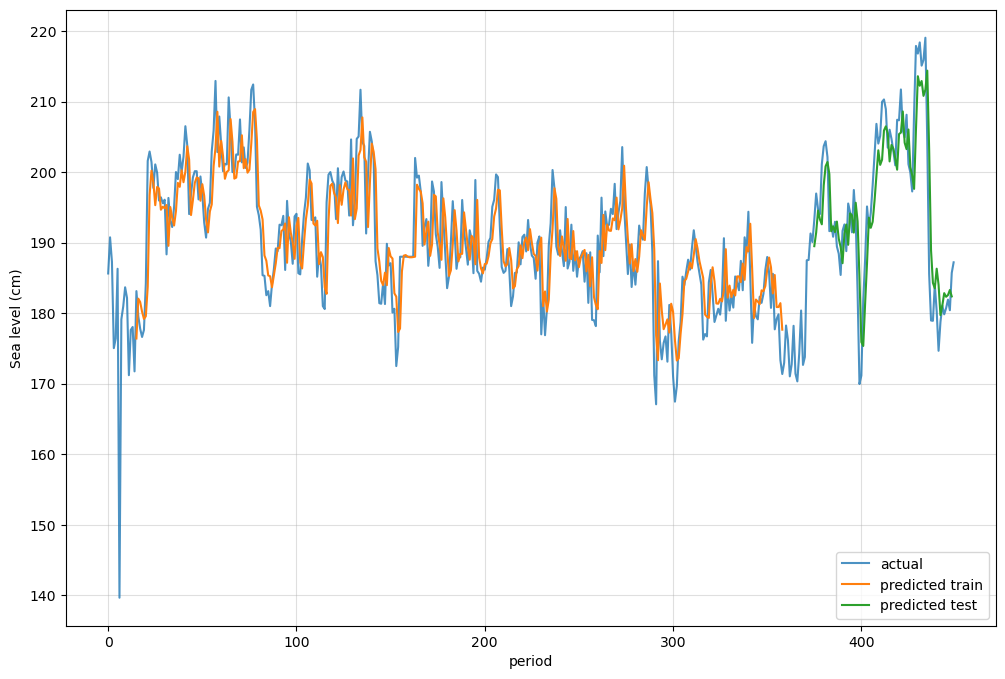

In [157]:
haha.plot_predicted(df, trainPredict.reshape(-1,1), testPredict.reshape(-1,1), t)

In [158]:
x_input=test[len(test)-t:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=t
i=0
pred_days = 30


while(i<pred_days):
    
    if(len(temp_input)>t):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


In [159]:
last_days=np.arange(1,t+1)
day_pred=np.arange(t+1,t+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [164]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

In [167]:
last_original_days_value[0:t+1] = df[len(df)-t:].reshape(1,-1).tolist()[0]
next_predicted_days_value[t+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days','Predicted next 30 days'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Sea level','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Sea level')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()



In [176]:
lstmdf=df.tolist()
lstmdf.extend((scaler.inverse_transform(lst_output).reshape(-1,1)).tolist())
lstmdf=np.array(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Sea level'])

fig = px.line(lstmdf,labels={'value': 'Sea level','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole data with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Label')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [174]:
lstmdf

[185.62499999999997,
 190.75,
 187.29166666666663,
 175.04166666666666,
 176.41666666666663,
 186.29166666666663,
 139.66666666666666,
 179.125,
 180.95833333333331,
 183.66666666666663,
 182.1666666666666,
 171.20833333333334,
 177.625,
 178.04166666666666,
 171.75,
 183.125,
 179.54166666666666,
 177.79166666666666,
 176.625,
 177.625,
 184.25,
 201.58333333333331,
 202.91666666666663,
 201.41666666666663,
 197.75,
 201.08333333333331,
 199.91666666666663,
 195.95833333333331,
 196.41666666666663,
 195.58333333333331,
 196.08333333333331,
 188.3333333333333,
 196.33333333333334,
 193.08333333333331,
 192.20833333333331,
 195.0416666666666,
 200.0,
 199.0,
 202.4583333333333,
 200.0,
 202.16666666666663,
 206.50000000000003,
 203.79166666666663,
 194.04166666666663,
 196.875,
 199.25,
 200.125,
 200.125,
 196.125,
 199.375,
 196.83333333333331,
 192.83333333333331,
 190.70833333333331,
 194.79166666666663,
 195.625,
 202.95833333333331,
 205.87500000000003,
 212.91666666666663,
 202.8